In [ ]:
import os
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scarches.models.scpoli import scPoli
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [ ]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(4, 4))
plt.rcParams['axes.facecolor'] = (1, 1, 1, 0)
%config InlineBackend.figure_formats = ['pdf']

In [ ]:
adata = sc.read('../datasets/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
# remove those that appear in fewer than 5% of the cells
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0] * 0.05))

In [ ]:
adata = adata[:, adata.var['feature_types']=='ATAC']

In [ ]:
adata.X = adata.X.todense()

In [ ]:
adata.X = adata.X.astype('float32')

In [ ]:
condition_key = 'Samplename'
cell_type_key = ['cell_type']

In [ ]:
import anndata as ad
from typing import Optional
def reads_to_fragments(
    adata: ad.AnnData,
    layer: Optional[str] = None,
    key_added: Optional[str] = None,
    copy: bool = False,
):
    """
    Function to convert read counts to appoximate fragment counts
    Parameters
    ----------
    adata
        AnnData object that contains read counts.
    layer
        Layer that the read counts are stored in.
    key_added
        Name of layer where the fragment counts will be stored. 
    copy
        Whether to modify copied input object. 
    """ 
    if copy:
        adata = adata.copy()
        
    if layer:
        data = np.ceil(adata.layers[layer].data/2)
    else:
        data = np.ceil(adata.X.data/2)
    
    if key_added:
        adata.layers[key_added] = adata.X.copy()
        adata.layers[key_added].data = data
    elif layer and key_added is None:
        adata.layers[layer].data = data
    elif layer is None and key_added is None:
        adata.X.data = data
    if copy:
        return adata  

In [ ]:
adata_trans = reads_to_fragments(adata, copy=True)

In [73]:
scpoli_model = scPoli(
    adata=adata_trans,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[100],
    latent_dim=25,
    embedding_dim=5,
    recon_loss='poisson',
)
scpoli_model.train(
    n_epochs=100,
    pretraining_epochs=95,
    use_early_stopping=False,
    alpha_epoch_anneal=1000,
    eta=0.5,
)

Embedding dictionary:
 	Num conditions: 13
 	Embedding dim: 5
Encoder Architecture:
	Input Layer in, out and cond: 16134 100 5
	Mean/Var Layer in/out: 100 25
Decoder Architecture:
	First Layer in, out and cond:  25 100 5
	Output Layer in/out:  100 16134 

Preparing (69249, 16134)
Splitting data (69249, 16134)
Instantiating dataset
Preparing (69249, 16134)
Splitting data (69249, 16134)
Instantiating dataset
Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss: 21606.2469815341 - val_cvae_loss: 21600.5908735795 - val_prototype_loss: 5.6561352015 - val_labeled_loss: 11.3122704029


In [ ]:
scpoli_model = scPoli.load('neurips_atac_final', adata_trans)

In [12]:
#get latent representation of reference data
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata_trans.X, 
    adata_trans.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata_trans.obs.copy()
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


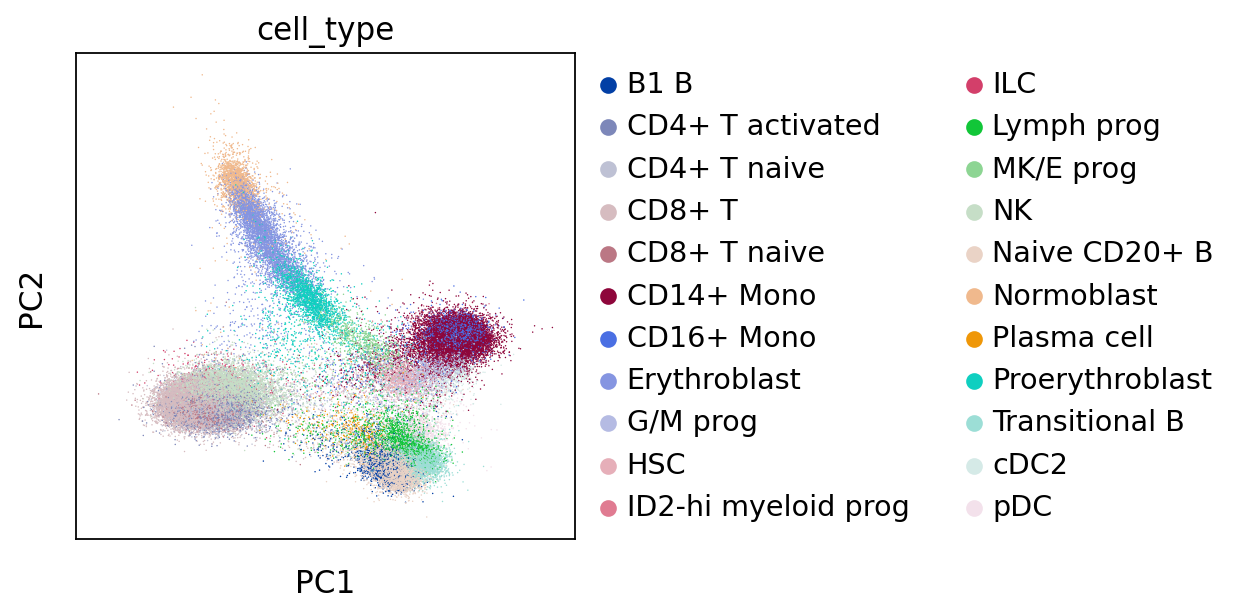

In [35]:
sc.pl.pca(adata_latent, color='cell_type')

In [14]:
sc.pl.pca(adata_latent, color='Site')

<Figure size 320x320 with 1 Axes>

In [15]:
sc.pl.umap(adata_latent, color='cell_type')

<Figure size 320x320 with 1 Axes>

In [16]:
sc.pl.umap(adata_latent, color='Site')

<Figure size 320x320 with 1 Axes>

In [17]:
from scib.metrics import metrics

In [81]:
adata_trans.write('../datasets/adata_trans.h5ad')
adata_latent.write('../datasets/adata_latent_atac.h5ad')

In [ ]:
adata_latent = sc.read('../datasets/adata_latent_atac.h5ad'

In [18]:
int_metrics = metrics(
    adata_trans,
    adata_latent,
    'Samplename',
    'cell_type',
    isolated_labels_asw_=True,
    silhouette_=True,
    graph_conn_=True,
    pcr_=True,
    isolated_labels_f1_=True,
    nmi_=True,
    ari_=True,
    #ilisi_=True,
    #clisi_=True,
)

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_pca
Isolated labels ASW...
Graph connectivity...


In [19]:
int_metrics

,0
NMI_cluster/label,0.762521
ARI_cluster/label,0.684398
ASW_label,0.546274
ASW_label/batch,0.904477
PCR_batch,0.177064
cell_cycle_conservation,NaN
isolated_label_F1,0.072316
isolated_label_silhouette,0.546543
graph_conn,0.958273
kBET,NaN


In [20]:
int_metrics.to_csv('int_metrics_scpoli_atac.csv')

In [21]:
int_metrics.mean()

0    0.581483
dtype: float64

In [22]:
adata_emb = scpoli_model.get_conditional_embeddings()
adata_emb.obs.reset_index(inplace=True)

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['site1_donor1_multiome', 'site1_donor2_multiome', 'site1_donor3_multiome', 'site2_donor1_multiome', 'site2_donor4_multiome']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [23]:
sc.pp.pca(adata_emb)

In [24]:
adata.obs.groupby('DonorID').size()

DonorID
10886     6740
11466     1771
12710     6111
13272     4325
15078    18467
16710     4895
18303     8604
19593     9876
28045     1679
28483     6781
dtype: int64

In [25]:
adata.obs.columns

Index(['GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors',
       'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments',
       'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction',
       'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order',
       'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality',
       'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'],
      dtype='object')

In [26]:
adata_emb.obs['DonorID'] = adata_emb.obs['DonorID'].astype('category')

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'Cell type')

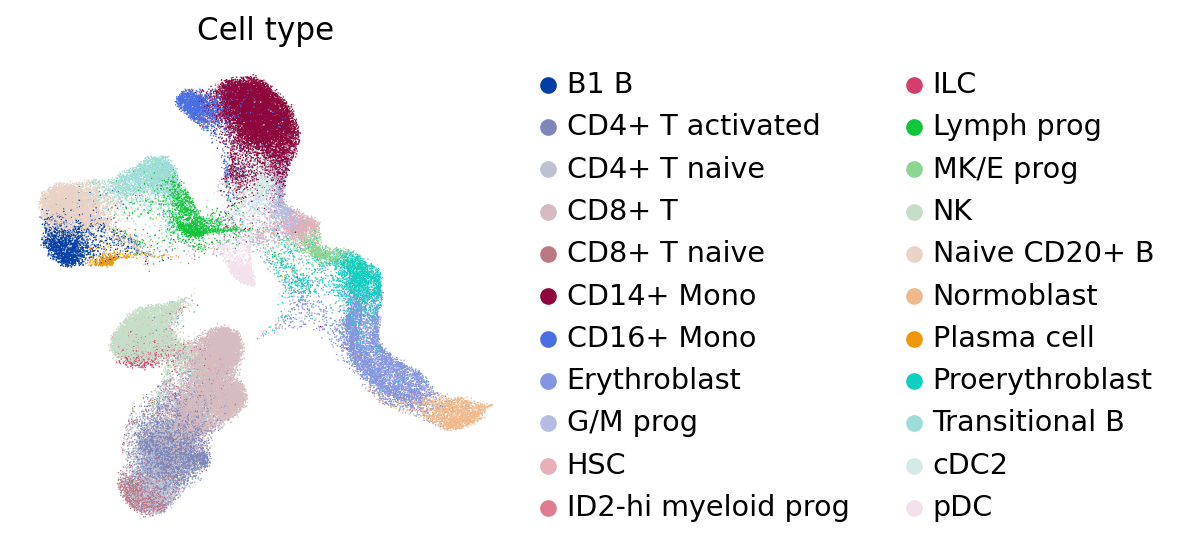

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_latent, color='cell_type', frameon=False, show=False, ax=ax)
ax.set_title('Cell type')

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'Site')

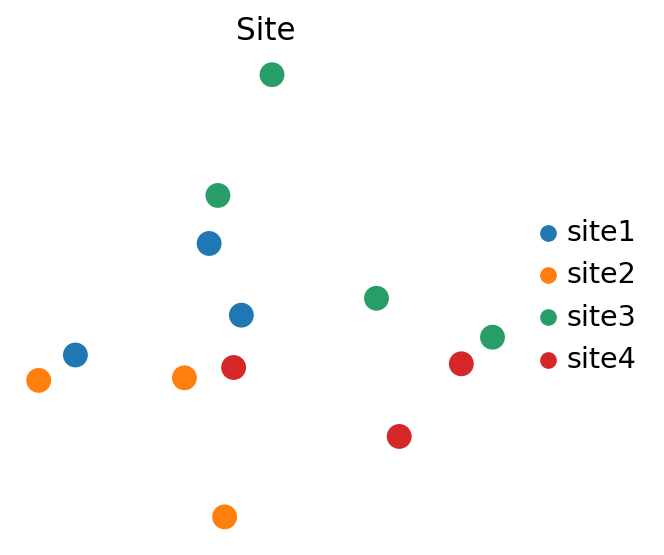

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.pca(adata_emb, color='Site', frameon=False, show=False, ax=ax, size=500, components='1, 2')
ax.set_title('Site')

In [38]:
import scvi

In [39]:
adata_scvi = adata.copy()

In [40]:
scvi.model.PEAKVI.setup_anndata(adata_scvi, batch_key='DonorID')

In [41]:
pvi = scvi.model.PEAKVI(adata_scvi, n_hidden=100, n_latent=25, n_layers_encoder=1, n_layers_decoder=1)


In [42]:
pvi.train(max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6928da6d40>
  self.pid = os.fork()
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6869154640>
  self.pid = os.fork()
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validati

Epoch 100/100: 100%|███████████████████████| 100/100 [11:29<00:00,  6.85s/it, loss=8.98e+07, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████| 100/100 [11:29<00:00,  6.89s/it, loss=8.98e+07, v_num=1]


In [51]:
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent


In [52]:
sc.pp.neighbors(adata, use_rep="X_PeakVI")

In [53]:
sc.tl.umap(adata)

In [55]:
latent = pvi.get_latent_representation()
adata_pvi = sc.AnnData(X=latent, obs=adata.obs)
sc.pp.pca(adata_pvi)

In [48]:
int_metrics_pvi = metrics(
    adata_scvi,
    adata_pvi,
    'Samplename',
    'cell_type',
    isolated_labels_asw_=True,
    silhouette_=True,
    graph_conn_=True,
    pcr_=True,
    isolated_labels_f1_=True,
    nmi_=True,
    ari_=True,
    #ilisi_=True,
    #clisi_=True,
)

/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_pca
Isolated labels ASW...
Graph connectivity...


In [49]:
int_metrics_pvi.mean()

0    0.560416
dtype: float64

In [57]:
int_metrics_pvi.to_csv('integration_metrics_pvi.csv')

In [59]:
int_metrics = int_metrics.assign(model='scPoli')
int_metrics_pvi = int_metrics_pvi.assign(model='PeakVI')
metrics_integration = pd.concat([int_metrics, int_metrics_pvi])

In [60]:
mean_metrics = metrics_integration.groupby('model').mean().reset_index()

In [61]:
mean_metrics.columns = ['model', 'integration_score']
mean_metrics['model'] = mean_metrics['model'].astype('category')
mean_metrics['model'] = mean_metrics['model'].cat.reorder_categories(['scPoli', 'PeakVI'])

Text(0, 0.5, 'Mean integration score')

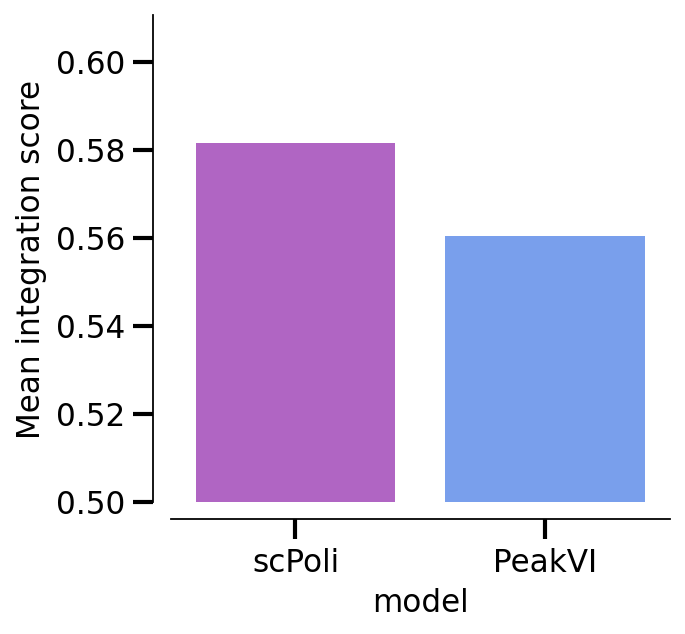

In [65]:
%config InlineBackend.figure_formats = ['pdf']
fig, ax = plt.subplots(1, 1)
sns.barplot(x='model', y='integration_score', data=mean_metrics, ax=ax, palette=['#BA55D3', '#6699ff'])
ax.grid(False)
sns.despine(offset=8)
ax.set_ylim(bottom=0.5)
ax.set_ylabel('Mean integration score')


In [ ]:
0.569389